## `PyTorch` without `torchvision`

### (i) Preprocessor and Setup

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Importing some packages.
from skimage.io import imread
from tqdm import tqdm

In [ ]:
import pandas as pd

train = pd.read_csv('/content/gdrive/My Drive/pytorch/flower_photos/training_set/training.csv')

train.head()

label                        Id image_type
0  tulips    420216121_3ee33723d7_m       .jpg
1  tulips  19425920580_cdc8f49aed_n       .jpg
2  tulips     8605564823_7a59d3d92a       .jpg
3  tulips    16303377824_6e9128b4bd       .jpg
4  tulips     2503489175_f0848d3e8e       .jpg

In [ ]:
training_path = '/content/gdrive/My Drive/pytorch/flower_photos/training_set/'

In [ ]:
train['label'] = train['label'].map({'tulips': 1, 'daisy': 2, 'dandelion': 3,
                                     'sunflowers': 4, 'roses': 5})

In [ ]:
train = train.rename(columns={'Id':'id'})

#### Preprocessor

In [ ]:
def preprocessor(data_path, labels_df):
        """
        This function preprocesses images by reading them in, resizing
        to a fixed shape and min-max transforming them before converting
        feature values to `float32` numeric values. (For ONNX.)
        (NB GPU usage for modelling is advisable.)
        
        params:
            data_path
                list of unprocessed images
            labels_df
                dataframe storing the image labels
                      
        returns:
            preprocessor
                preprocessed image data
                  
        """
           
        import cv2

        preprocessed_img = []
        for img_name in tqdm(labels_df['id']):
            image_path = data_path + str(img_name) + '.jpg' # Define image path.
            img = cv2.imread(image_path) # Read in the image.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(28, 28)) # Smaller works better.
            img = img / 255.0 # Normalization.
            img = img.astype('float32') # float32 for ONNX.
            preprocessed_img.append(img) # Append images to a list.
        return preprocessed_img

In [ ]:
import numpy as np

train_x = np.array(preprocessor(training_path, train)) # Convert to a numpy array.
train_y = train['label'].values # Define the target.
train_x.shape

100%|██████████| 2935/2935 [00:14<00:00, 201.43it/s]


(2935, 28, 28, 3)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f315afbdfd0>,
 <matplotlib.image.AxesImage at 0x7f315af78240>)

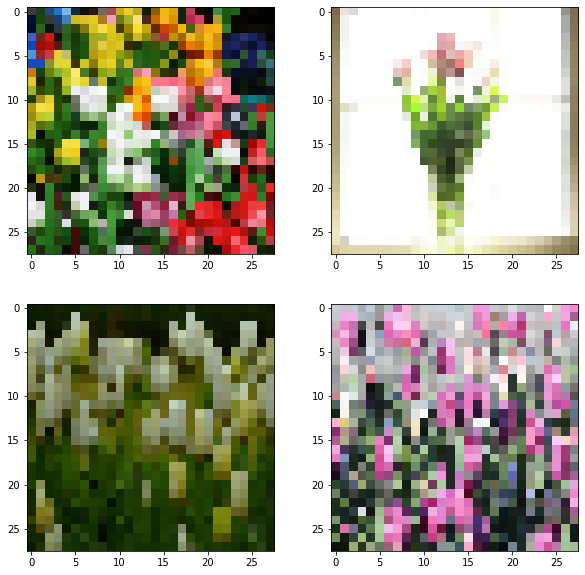

In [ ]:
# Visualize some images.
import matplotlib.pyplot as plt
%matplotlib inline

i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25])
plt.subplot(223), plt.imshow(train_x[i+50])
plt.subplot(224), plt.imshow(train_x[i+75])

In [ ]:
# `train_test_split()`.
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

(((2641, 28, 28, 3), (2641,)), ((294, 28, 28, 3), (294,)))

In [ ]:
train_y # Sanity check. Looks right! NB tulips = 1, daisy = 2, dandelion = 3, sunflowers = 4, roses = 5.

array([1, 5, 5, ..., 3, 1, 2])

In [ ]:
# Some PyTorch packages.
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
# Convert training images to torch format.
train_x = np.transpose(train_x, (0, 3, 1, 2))
train_x  = torch.from_numpy(train_x)

# Convert the target to torch format.
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

train_x.shape, train_y.shape # Check shape.

(torch.Size([2641, 3, 28, 28]), torch.Size([2641]))

In [ ]:
# Same conversions for the test set.
test_x = np.transpose(test_x, (0, 3, 1, 2))
test_x  = torch.from_numpy(test_x)

test_y = test_y.astype(int);
test_y = torch.from_numpy(test_y)

test_x.shape, test_y.shape # Check shape.

(torch.Size([294, 3, 28, 28]), torch.Size([294]))

### (ii) Train Model Using `torch`

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Define a 2D convolution layer.
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1), # https://stackoverflow.com/questions/56675943/meaning-of-parameters-in-torch-nn-conv2d
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Another 2D convolution layer.
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Define the forward pass.   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
model = Net() # Define model.
optimizer = Adam(model.parameters(), lr=0.07) # Define optimizer.
criterion = CrossEntropyLoss() # Define loss function.
# Check if GPU is available.
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    x_train, y_train = Variable(train_x), Variable(train_y) # Retrieve the training-set.
    x_test, y_test = Variable(test_x), Variable(test_y) # Retrieve the test-set.
    # Convert the data to GPU format.
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_test = x_test.cuda()
        y_test = y_test.cuda()

    optimizer.zero_grad() # Clear the Gradients of the model params.
    
    # Prediction for training and test sets.
    output_train = model(x_train)
    output_test = model(x_test)

    # Compute the training and test loss.
    loss_train = criterion(output_train, y_train)
    loss_test = criterion(output_test, y_test)
    train_losses.append(loss_train)
    test_losses.append(loss_test)

    # Compute the updated weights of all the model params.
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_test) # Print the test loss.

In [ ]:
n_epochs = 75 # Define number of epochs.
train_losses = [] # Empty list to store training losses.
test_losses = [] # Ditto for test losses.

# Train the model.
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.4768, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(4.6536, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.6438, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.5271, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.5482, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.6050, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.6071, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(1.5667, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(1.5607, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(1.5520, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(1.5165, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(1.4781, device='c

In [ ]:
# Prediction for training-set.
from sklearn.metrics import accuracy_score

with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(train_y, predictions) # Accuracy on training set.

0.5028398333964408